In [10]:
# third party imports
import numpy as np
from numpy import exp, log, log10, sqrt, zeros, ones, linspace
import matplotlib.pyplot as plt
import numba
import pickle

# other project files
import modes
import spectra
import util

In [13]:
# numerical parameters
NT = 2**13
NK = 2**11
NX = 10000
L_MAX = 2500
xmin = 0.01
xmax = 3000
a0 = 1.e-6
a0_pca = 5.e-5
a_rec = 1/1100
# arrays
A = np.linspace(a0, a_rec, 2*NT)
K = np.linspace(.1, 800, NK)
K_Mpc = K/4400
L = np.array([i for i in range(2, 50, 1)]+[i for i in range(50, 200, 5)] +
                  [i for i in range(200, L_MAX+1, 20)])
L_eval = np.arange(2, L_MAX+1)
NL = len(L)
X = np.linspace(xmin, xmax, NX)
JLX, DJLX = spectra.get_bessels(L, X)

Bessel functions loaded from file.


In [14]:
# physical parameters
h = 0.6774
As = np.exp(3.064)/1.e10 # scalar perturbation amplitude
TCMB0 = 2.72548 * 1.e6 # CMB temp (microK)
OmegaM0 = 0.3089
OmegaB0 = 0.0486
OmegaR0 = 4.2e-5/h**2
OmegaN0 = OmegaR0*(1-1/1.68)
OmegaG0 = OmegaR0 - OmegaN0
OmegaC0 = OmegaM0 - OmegaB0
wC = np.zeros(2*NT)
wN = np.ones(2*NT)*1/3
cs2C = np.zeros((2*NT, NK))
cs2N = np.ones((2*NT, NK))*1/3
params_F = [wC, cs2C, wN, cs2N, OmegaB0, OmegaC0, OmegaG0, OmegaN0, As, TCMB0, h]

Cl = spectra.get_Cl_3fld(L, L_eval, X, JLX, DJLX, A, K, *params_F)
err = spectra.get_Cl_err(L_eval,Cl)
Sigma = np.diag(err**2)


In [15]:
@numba.njit
def square_basis(theta, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    for i in range(NC**2):
        r,c = i//NC, i%NC
        out[r*width:(r+1)*width, c*height:(c+1)*height] = theta[i]
    out[:,A[::2] < a0_pca]=0
    return out.T

@numba.njit
def square_basis_inv(X, NC):
    v= np.zeros(NC**2)
    width = NT//NC
    height = NK//NC
    for i in range(NC**2):
        v[i] = X[(i%NC)*width+width-1, (i//NC)*height+height-1]
    return v

@numba.njit
def double_sample(v):
    M = int(sqrt(len(v)))
    N = 2*M
    v2  = np.zeros(N**2)
    
    for i in range(M**2):
        R1 = (N*i)//M + N*(i//M)
        R2 = R1+1
        R3 = R1+N
        R4 = R2+N
        v2[R1] = v2[R2] = v2[R3] = v2[R4] = v[i]
    return v2/2


def get_square(n, val, NC):
    height = NT//NC
    width = NK//NC
    out = np.zeros((NK, NT))
    r,c = n//NC, n%NC
    out[r*width:(r+1)*width, c*height:(c+1)*height] = val
    out[:,A[::2] < a0_pca]=0
    return out.T

In [16]:
@numba.njit()
def powit(J_static, Sigma, v0):
    """Power iteration eigensolver. Gets largest m eigenvalues of J^T \Sigma J."""
    J = np.copy(J_static)
    n = 20
    N = len(J.T)
    err = np.zeros(n)
    
    # arrays U and L eigenvectors and eigenvalues respectively
    U = np.zeros(N)
    L = 0
    
    # initialize the eigenvector 'guess' to a random unit vector
    u = v0
    for j in range(n):
        # compute the product (J^T \Sigma J)u step by step.
        u_n = J.T@(np.diag(Sigma)@(J@u))
        u_n/=np.linalg.norm(u_n)
        err[j]=np.linalg.norm(u_n-u)
        u = u_n
    U=u
    # compute the rayleigh quotient without making a big matrix:
    RQ_num = (J@u)@np.diag(Sigma)@(J@u)
    L=RQ_num/(u.T@u)
    return L,U, err

#@numba.njit()
def Powit(J_static, Sigma, m, V0):
    """Power iteration eigensolver. Gets largest m eigenvalues of J^T \Sigma J."""
    J = np.copy(J_static)
    n = 50
    # get N largest eigenvalues and eigenvectors of A using power iteration
    N = len(J.T)
    err = np.zeros((m,n))
    
    # arrays U and L eigenvectors and eigenvalues respectively
    U = np.zeros((N,m))
    L = np.zeros(m)
    for i in range(m):
        # initialize the eigenvector guess
        u = V0[:,i]
        # iterate to find the ith eigenvector
        for j in range(n):
            # compute the product (J^T \Sigma J)u step by step.
            u_n = J.T@(np.diag(Sigma)@(J@u))
            u_n/=np.linalg.norm(u_n)
            err[i,j]=np.linalg.norm(u_n-u)
            u = u_n
        U[:,i]=u
        # compute the rayleigh quotient without making a big matrix:
        RQ_num = (J@u)@np.diag(Sigma)@(J@u)
        L[i]=RQ_num/(u.T@u)
        J -= np.outer(J@u,u)
    return L,U, err


In [76]:
def RRMSE(a,b):
    RMSE = sqrt(np.mean((a-b)**2))
    return RMSE/sqrt(np.mean(b**2))

powit_err_q = np.zeros((6,5))

In [91]:
q = 8
N = 2**q
M = 2**(q-1)

J = pickle.load(open("output/cs2-only/J_q-{}_t-7.p".format(q), "rb"))
PC_powit = np.zeros((10, NT, NK))

In [80]:
#PC = pickle.load(open("output/cs2-only/PC_q-{}_t-7.p".format(q), "rb"))
PC_prev = pickle.load(open("output/cs2-only/PC_q-{}_t-7.p".format(q-1), "rb"))
SV_prev = pickle.load(open("output/cs2-only/SV_q-{}_t-7.p".format(q-1), "rb"))

v_init = np.random.rand(N**2,10)
v_init2 = np.ones((N**2,10))
for i in range(10):
    PV_prev = square_basis_inv(PC_prev[i,:,:], M)
    v_init2[:,i] = double_sample(PV_prev)

In [81]:
SV, PV, err = Powit(J,np.diag(1/Sigma),10,v_init)
SV2, PV2, err2 = Powit(J,np.diag(1/Sigma),10,v_init2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [92]:
for i in range(10):
    PC_powit[i] = square_basis(PV2[:,i], N)
    if np.sign(PC_powit[i,3000,1000])!=np.sign(PC_prev[i,3000,1000]):
        PC_powit[i]*=-1
    #PC_powit[i]*=-1

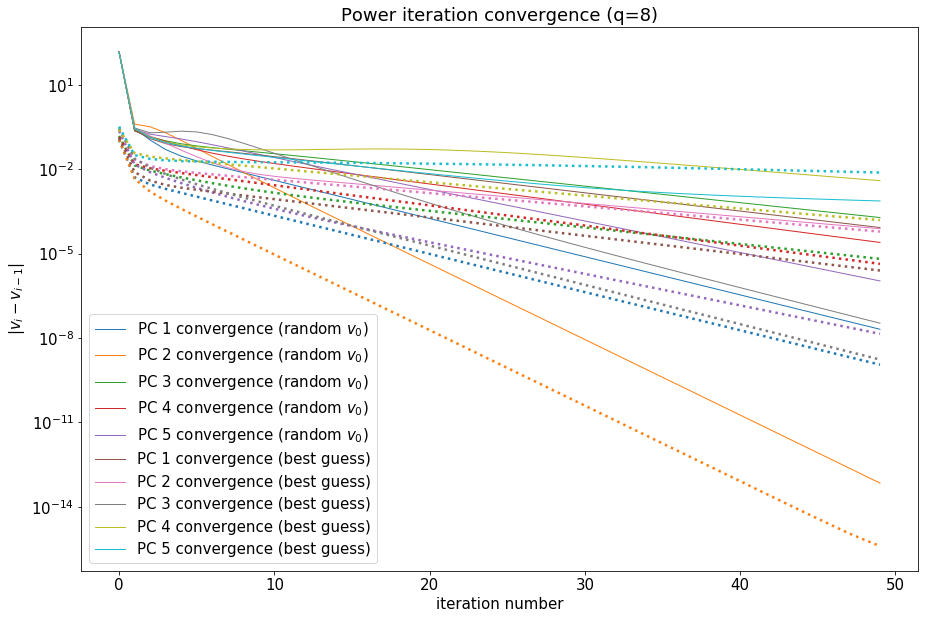

In [93]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
plt.plot(err.T, linewidth=1)
plt.gca().set_prop_cycle(None)
plt.plot(err2.T,linestyle=':',linewidth=2.5)
plt.semilogy()

plt.legend(['PC 1 convergence (random $v_0$)',
            'PC 2 convergence (random $v_0$)',
           'PC 3 convergence (random $v_0$)',
           'PC 4 convergence (random $v_0$)',
           'PC 5 convergence (random $v_0$)',
           'PC 1 convergence (best guess)',
           'PC 2 convergence (best guess)',
           'PC 3 convergence (best guess)',
           'PC 4 convergence (best guess)',
           'PC 5 convergence (best guess)'])
plt.xlabel('iteration number')
plt.ylabel('$|v_i - v_{i-1}|$')
plt.title('Power iteration convergence (q={})'.format(q))
plt.show()
plt.rcParams.update({'font.size': 10})

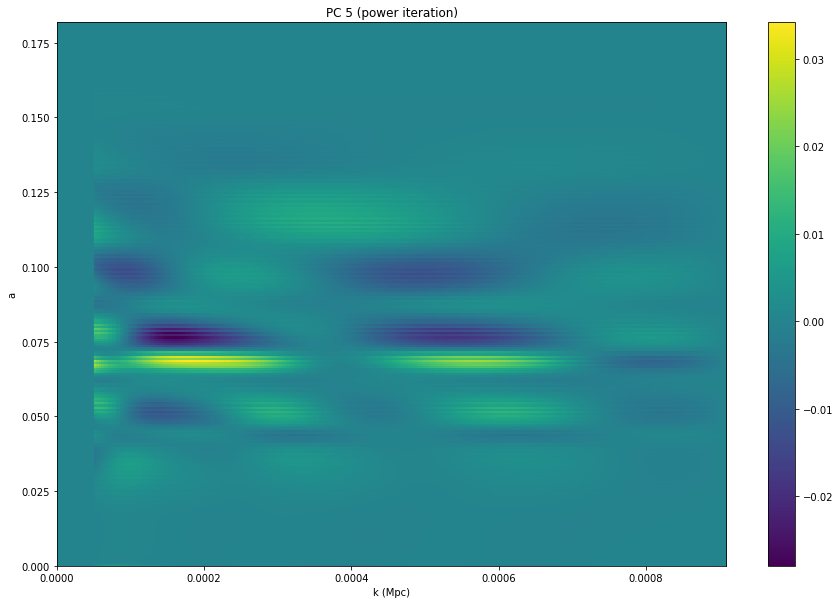

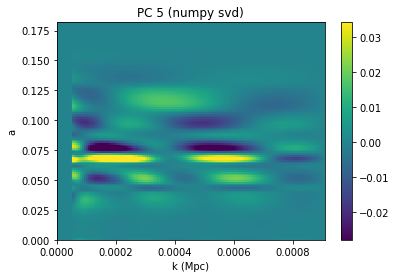

[0.50623259 0.50652308 0.51386169 0.51400042 0.52741963]


In [94]:

n = 4

plt.figure(figsize=(15,10))
vmin, vmax = np.min(PC_powit[n,:,:]), np.max(PC_powit[n,:,:])
plt.imshow(PC_powit[n,:,:].T, aspect='auto',extent=[0,a_rec,0,K_Mpc[-1]],vmin=vmin, vmax=vmax)
plt.xlabel('k (Mpc)')
plt.ylabel('a')
plt.colorbar()
plt.title('PC {} (power iteration)'.format(n+1))
plt.show()

plt.imshow(PC_prev[n,:,:].T, aspect='auto',extent=[0,a_rec,0,K_Mpc[-1]],vmin=vmin, vmax=vmax)
plt.xlabel('k (Mpc)')
plt.ylabel('a')
plt.colorbar()
plt.title('PC {} (numpy svd)'.format(n+1))
plt.show()

powit_err_q[q-5,:] = [RRMSE(PC_powit[n,:,:], PC_prev[n,:,:]) for n in range(5)]
print(powit_err_q[q-5,:])

In [95]:
print(powit_err_q)

[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.50623259 0.50652308 0.51386169 0.51400042 0.52741963]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


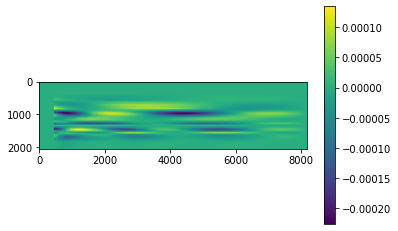

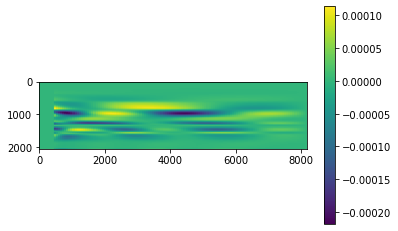

0.16784436915987636


In [104]:
n=3
a = PC_powit[n,:,:].T/sqrt(SV[n])
b = PC_prev[n,:,:].T/sqrt(SV_prev[n])

plt.imshow(a)
plt.colorbar()
plt.show()
plt.imshow(b)
plt.colorbar()
plt.show()

print(RRMSE(a,b))

In [97]:
#PC_prev = pickle.load(open("output/cs2-only/PC_q-{}_t-7.p".format(q-1), "rb"))
#SV_prev = pickle.load(open("output/cs2-only/SV_q-{}_t-7.p".format(q-1), "rb"))
pickle.dump(PC_powit, open("output/cs2-only/PC_q-{}_t-7.p".format(q), "wb" ) )
pickle.dump(SV2, open("output/cs2-only/SV_q-{}_t-7.p".format(q), "wb" ) )